<a href="https://colab.research.google.com/github/EthanXC/RedditProject/blob/main/RedditProject1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
!pip install datasets
# FYI the accellerate -u is very important to avoid version issues with torch
!pip install transformers
!pip install accelerate -U
from transformers import AutoTokenizer, RobertaForSequenceClassification
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
!pip install datasets transformers torch evaluate nltk rouge_score
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [89]:
from datasets import load_dataset
dataset = load_dataset("fddemarco/pushshift-reddit-comments", streaming = True)
it = iter(dataset['train'])
extract_data = next(it)
#print(extract_data)

print(extract_data['body'])
#testing if we can get a sample comment

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

isn ' t this against the first amendment ? doesn ' t the first amendment give us the right to assemble and protest ?


In [90]:
data = {
    'column1_name': ['text'],
    'column2_name': ['score'],
    'column3_name': ['labels']
}

df = pd.DataFrame(data)

In [91]:
df_pre_clean = df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   column1_name  1 non-null      object
 1   column2_name  1 non-null      object
 2   column3_name  1 non-null      object
dtypes: object(3)
memory usage: 152.0+ bytes


In [100]:
# Initialize an empty DataFrame with columns
df = pd.DataFrame(columns=['text', 'score', 'labels'])

nsfw_keywords = ['nsfw', 'adult', 'sex', 'porn', 'xxx', 'gonewild', 'nudes', 'slut', 'WTF',
'hentai', 'cum', 'rule34', 'pussy', 'onlyfans', 'milf', 'nude', 'boob']

subreddit_counts = {}

row_variable = 20000 # only 10,000 rows

while df.shape[0] < row_variable:
    extract_data = next(it)
    text = extract_data['body']
    score = extract_data['score']
    labels = extract_data['subreddit']

    if any(keyword in labels.lower() for keyword in nsfw_keywords):
      continue

     # Check and update subreddit count
    if labels in subreddit_counts:
        if subreddit_counts[labels] >= (0.01*row_variable):
            continue  # Skip this subreddit if it has already 500 entries
        subreddit_counts[labels] += 1
    else:
        subreddit_counts[labels] = 1

    new_row_data = {'text': text, "score": score, "labels": labels}
    df.loc[len(df)] = new_row_data

    #if i % 1000 == 0:
        #print(i)
        #print(new_row_data)





In [101]:
if np.isinf(df['score']).any():
  print("HELLO")

In [102]:
id2label = dict(enumerate(set(df['labels'])))
#print(id2label)

In [103]:

# Load roberta model and tokenizer filling out the code below based on the documentation HINT: Click on on use in transformers and the code will be there
#model_name = "Roberta model"# code unnessisary but I like to use it to store the string name to make the code cleaner
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels = len(id2label))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [104]:
nan_rows = df[df.isna().T.any().T]
nan_rows.head()
null_rows = df[df.isnull().any(axis=1)]
null_rows.head()
if np.isinf(df['score']).any():
  print("HELLO")

df = df[df['score'] > -50]

In [105]:
df['labels'].value_counts()

labels
gaming           200
nfl              200
pics             200
politics         200
worldnews        200
                ... 
aggies             1
FML                1
Eesti              1
futuregarage       1
buildapcsales      1
Name: count, Length: 1558, dtype: int64

In [106]:
label_counts = df['labels'].value_counts()
labels_to_remove = label_counts[label_counts < 2].index
df = df[~df['labels'].isin(labels_to_remove)]

In [111]:
df['labels'].info()

<class 'pandas.core.series.Series'>
Index: 19479 entries, 0 to 19999
Series name: labels
Non-Null Count  Dtype 
--------------  ----- 
19479 non-null  object
dtypes: object(1)
memory usage: 304.4+ KB


In [112]:
from sklearn.model_selection import train_test_split

#TODO: Complete this line using the train_test_split function and set the test size to .21
train_texts, val_texts, train_labels, val_labels = train_test_split(df['text'], df['labels'], test_size=0.21, stratify = df['labels'])


tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
# Reset the index
train_texts, train_labels = train_texts.reset_index(drop=True), train_labels.reset_index(drop=True)
val_texts, val_labels = val_texts.reset_index(drop=True), val_labels.reset_index(drop=True)
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, return_tensors = "pt")
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, return_tensors = "pt")

In [113]:
id2label_reversed = {v: k for k, v in id2label.items()}
#print(id2label_reversed)

In [114]:
import torch as pt

class SpamDataset(pt.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.values

    def __getitem__(self, idx):
        item = {key: pt.tensor(val[idx]) for key, val in self.encodings.items()}
        if len(self.labels) > 0:  # Check if labels array has any elements
            labels = self.labels[idx]
            #print(labels)
            labels_converted = id2label_reversed[labels]
            #print(labels_converted)
            item["labels"] = pt.tensor(labels_converted)
        return item
    def __len__(self):
        #print(len(self.labels))
        return len(self.labels)

def list_of_dicts_to_dict_of_lists(d):
  dic = d[0]
  keys = dic.keys()
  values = [dic.values() for dic in d]
  return {k: list(v) for k,v in zip(keys, zip(*values))}

In [115]:
Train_Dataset = SpamDataset(train_encodings, train_labels)
Val_Dataset = SpamDataset(val_encodings, val_labels)

In [116]:
from sklearn.metrics import accuracy_score

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [117]:
#%set_env CUDA_LAUNCH_BLOCKING=1

In [118]:
#%env CUDA_LAUNCH_BLOCKING

In [119]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs, let's try 1 for now
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)



trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = Train_Dataset,
    eval_dataset = Val_Dataset,
    compute_metrics = compute_metrics
    #TODO: figure out what 5 params we need here. There should be 5 and the last is how we compute the metrics later . . .
)

In [120]:
# TODO: Train the model (HINT: this is 1 short line of code just calling the trainer)
trainer.train()

<ipython-input-114-d8518a5f2f5c>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: pt.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
10,7.362800
20,7.330300
30,7.364900
40,7.337200
50,7.335400
60,7.354000
70,7.368200
80,7.342600
90,7.326900
100,7.284800


<ipython-input-114-d8518a5f2f5c>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: pt.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-114-d8518a5f2f5c>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: pt.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-114-d8518a5f2f5c>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: pt.tensor(val[idx]) for key, val in self.encodings.items()}


TrainOutput(global_step=1924, training_loss=6.221630017127912, metrics={'train_runtime': 1380.5796, 'train_samples_per_second': 11.146, 'train_steps_per_second': 1.394, 'total_flos': 4105316816707584.0, 'train_loss': 6.221630017127912, 'epoch': 1.0})

In [121]:
#TODO use the evaluate method on the trainer to get and print the results. Feel free to look at Huggingface Docs
results = trainer.evaluate()

<ipython-input-114-d8518a5f2f5c>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: pt.tensor(val[idx]) for key, val in self.encodings.items()}


In [129]:
print(results)

{'eval_loss': 5.893246173858643, 'eval_accuracy': 0.017355169885113663, 'eval_runtime': 118.1541, 'eval_samples_per_second': 34.624, 'eval_steps_per_second': 1.083, 'epoch': 1.0}


In [122]:
# TODO: Save the model
trainer.save_model('my_model')

In [123]:
# TODO: Now to finish off I want you to load the model you trained and saved and write a fake spam email for it mthen have the model classify it
model = AutoModelForSequenceClassification.from_pretrained("my_model")
msg = "boston celtics"
msg_encodings = tokenizer(msg, truncation=True, padding=True, return_tensors = "pt")

outputs = model(**msg_encodings)
probabilities = torch.softmax(outputs.logits[0], dim = 0 )
sort_prob = probabilities.sort(descending = True)
#print(f"outputs: {outputs}")


In [124]:
outputs.logits.shape
len(id2label)
probabilities = torch.softmax(outputs.logits[0], dim = 0 )
sort_prob = probabilities.sort(descending = True)
print(sort_prob.values[0].item())
print(id2label[sort_prob.indices[0].item()])



0.014042320661246777
circlejerk


In [130]:
def print_out_top_x_probs(phrase):
    phrase_encoding = tokenizer(phrase, truncation=True, padding=True, return_tensors="pt")
    output = model(**phrase_encoding)
    probabilities = torch.softmax(output.logits[0], dim=0)
    sort_prob_values, sort_prob_indices = probabilities.sort(descending=True)

    for n in range(10):
        tensor_probs = sort_prob_values[n]
        index = sort_prob_indices[n]
        sort_prob_index_int = index.item()
        subreddit_string = id2label[sort_prob_index_int]
        print(f"{n+1}. {subreddit_string} ({'%.2f' % (tensor_probs*100)}%)")


In [135]:
phrase = "boston gets bombed"
iterations = 5
print_out_top_x_probs(phrase)

1. circlejerk (1.40%)
2. funny (1.33%)
3. SteamGameSwap (1.31%)
4. swtor (1.30%)
5. trees (1.30%)
6. WTF (1.24%)
7. tf2trade (1.23%)
8. pics (1.22%)
9. SteamTrade (1.21%)
10. todayilearned (1.21%)


In [127]:
# it's time to graph!

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy
    }


ValueError: x and y must have same first dimension, but have shapes (1,) and (3,)

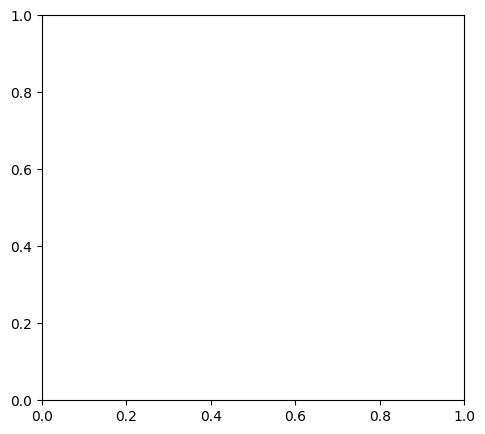

In [128]:
import matplotlib.pyplot as plt

# this is fake data, replace with real data
epochs = 1
loss = [0.30, 0.24, 0.20]
f1_scores = [0.82, 0.85, 0.87]

plt.figure(figsize=(12, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plotting F1 Score
plt.subplot(1, 2, 2)
plt.plot(epochs, f1_scores, label='F1 Score', marker='o', color='r')
plt.title('F1 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
